In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from utils.preprocessing import preprocessing
from utils.scores import display_silhouettes
from utils.display import display_clusters

# 1/ Dataset upload/overview

In [3]:
df = pd.read_csv("../data/kaya_dataset.csv")
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              7745 non-null   object 
 1   year                 7745 non-null   int64  
 2   iso_code             7745 non-null   object 
 3   co2                  7745 non-null   float64
 4   energy               7745 non-null   float64
 5   gdp                  7745 non-null   float64
 6   population           7745 non-null   float64
 7   co2_per_unit_energy  7745 non-null   float64
 8   energy_per_gdp       7745 non-null   float64
 9   gdp_per_capita       7745 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 605.2+ KB
None


,year,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
count,7745.000000,7745.000000,7.745000e+03,7.745000e+03,7.745000e+03,7745.000000,7745.000000,7745.000000
mean,1997.914009,169.430360,7.407782e+11,4.259151e+11,4.002676e+07,0.239455,1.674191,13025.601709
std,15.104324,683.710379,2.786040e+12,1.488989e+12,1.350935e+08,0.200058,1.631089,14718.564983
min,1965.000000,0.022000,9.765923e+07,1.642060e+08,6.408200e+04,0.018000,0.078000,361.188725
25%,1986.000000,3.691000,1.850453e+10,1.803369e+10,3.593782e+06,0.186000,0.767000,2808.878751
50%,1999.000000,20.870000,8.890039e+10,6.434611e+10,9.754398e+06,0.221000,1.245000,7828.856656
75%,2011.000000,84.838000,4.128210e+11,2.542891e+11,2.810118e+07,0.261000,2.053000,18309.742796
max,2022.000000,11711.808000,4.451869e+13,2.696602e+13,1.426437e+09,10.689000,25.253000,163531.400281


# 2/ data and feature selection

In [4]:
# countries selection :
countries = df.country.unique()
# year selection :
# years = df.year.unique()
years = [2022]  # only 2022
# common columns :
# cols = df.columns.tolist() # select all
cols = ['country', 'year', 'iso_code']
# features selection :
features_1 = ['co2', 'energy', 'gdp', 'population']
features_2 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita']
features_3 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population']
features = features_2

# DBSCAN parameters
# eps_values = [0.25, 0.3, 0.35]
# min_samples_values = [2]
eps_values = [0.20, 0.25, 0.30]
min_samples_values = [2,3,4]

rs = 42 # seed for random functions (center first position)

# 3/ Results

In [5]:
def dbscan_training(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    return cluster_labels

In [6]:
# check rapide :
df, X =  preprocessing(df, years, countries, cols, features)
cluster_labels = dbscan_training(X, 0.2, 3)

n_total = len(cluster_labels)
n_clusters = len(set(cluster_labels) - {-1})
n_outliers = (cluster_labels==-1).sum()
# print(f"total : {n_total}, nombre de clusters : {n_clusters}")
for i in range(-1, n_clusters):
    if i==-1 :
        print(f"- outliers : n= {n_outliers}")
    else :       
        print(f"- cluster {i}: n= {(cluster_labels==i).sum()}")

centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])


- outliers : n= 143
- cluster 0: n= 4
- cluster 1: n= 3
- cluster 2: n= 4
- cluster 3: n= 4
- cluster 4: n= 3
- cluster 5: n= 3


>>>  12
>>>  6
>>>  2
>>>  19
>>>  8
>>>  2
>>>  24
>>>  11
>>>  6


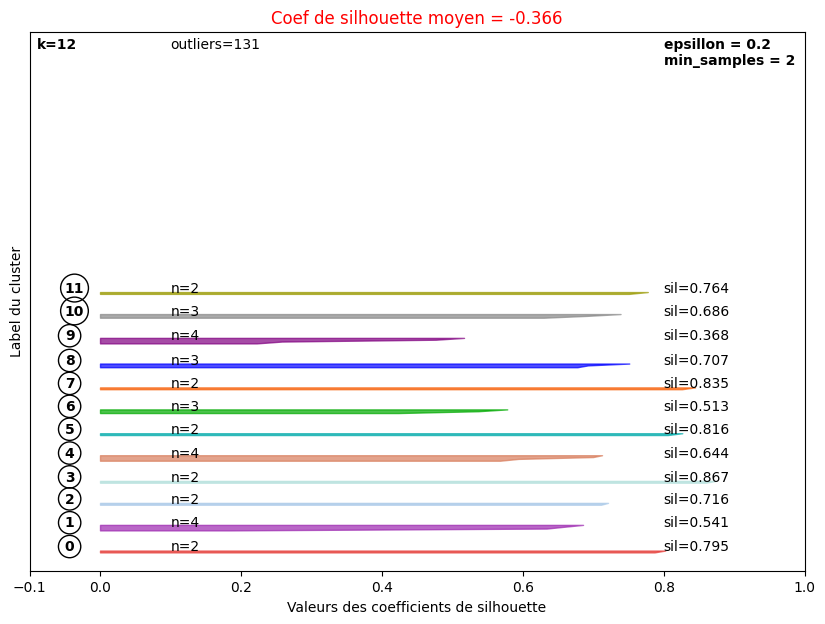

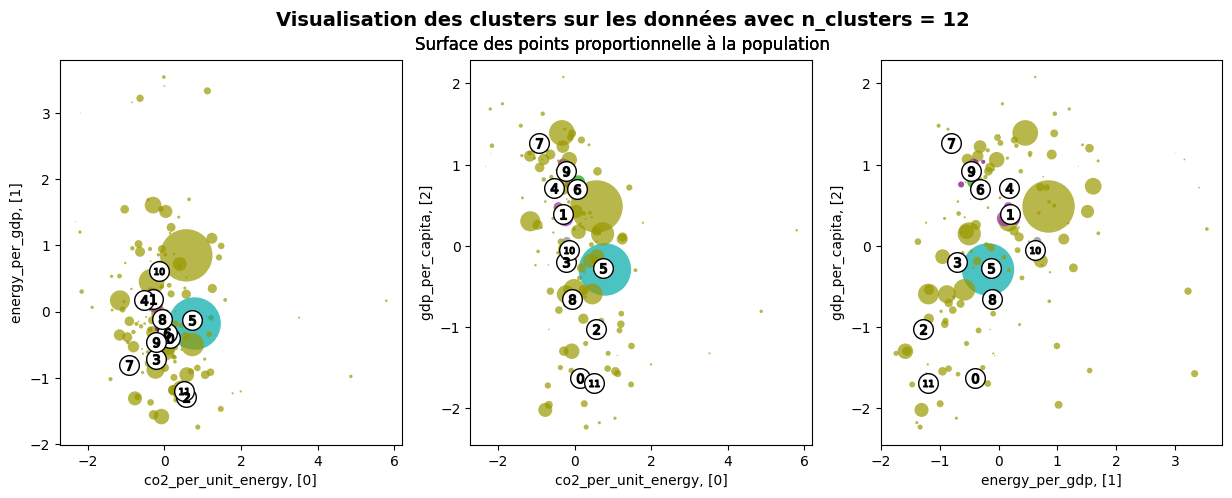

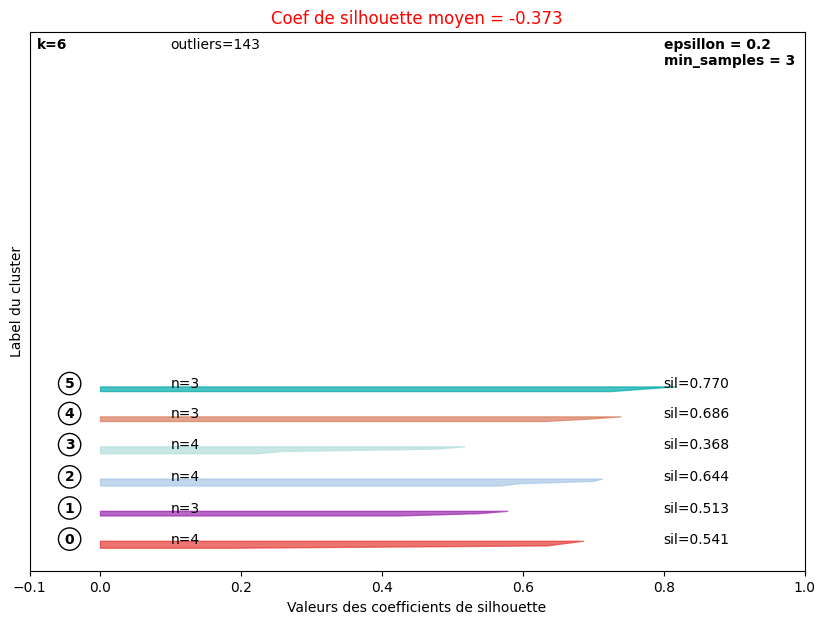

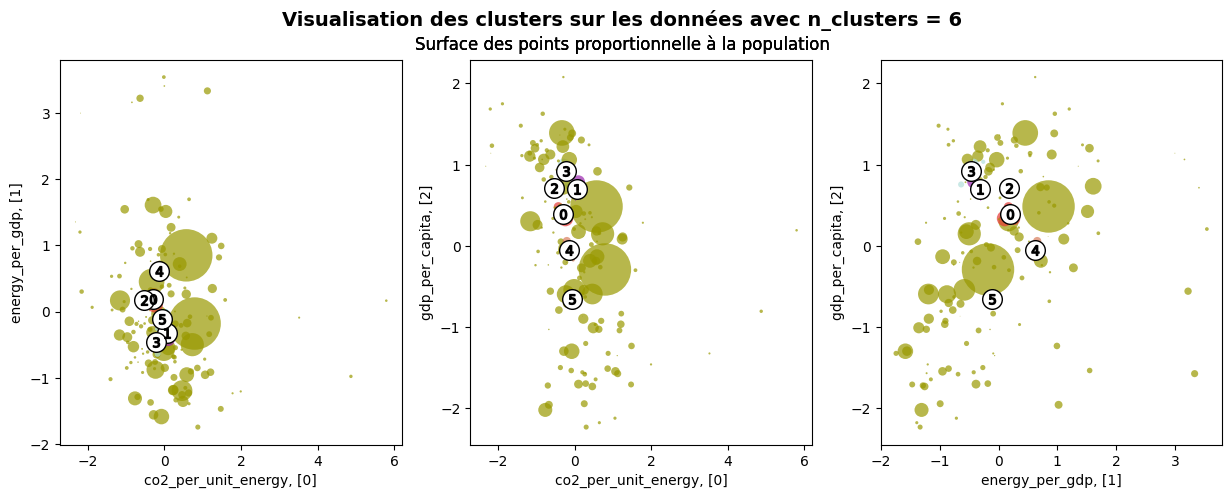

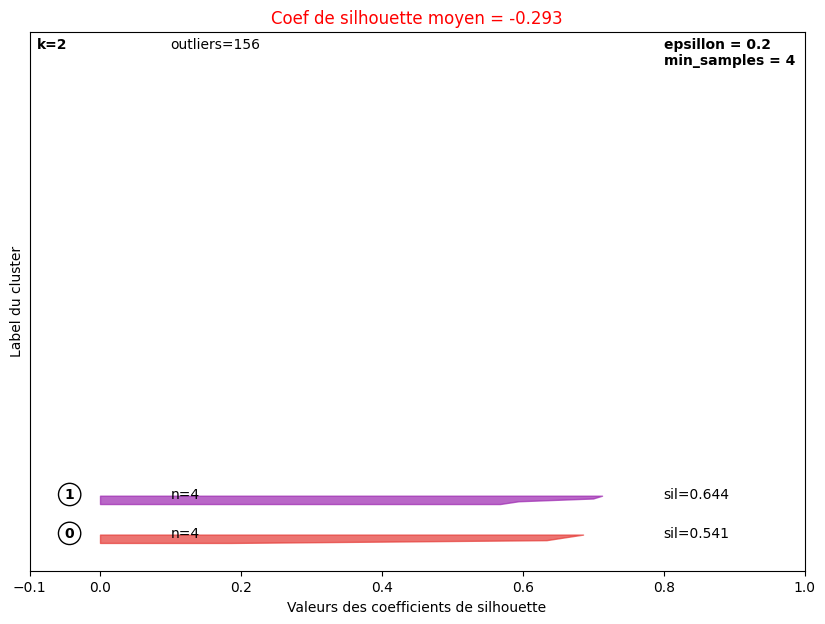

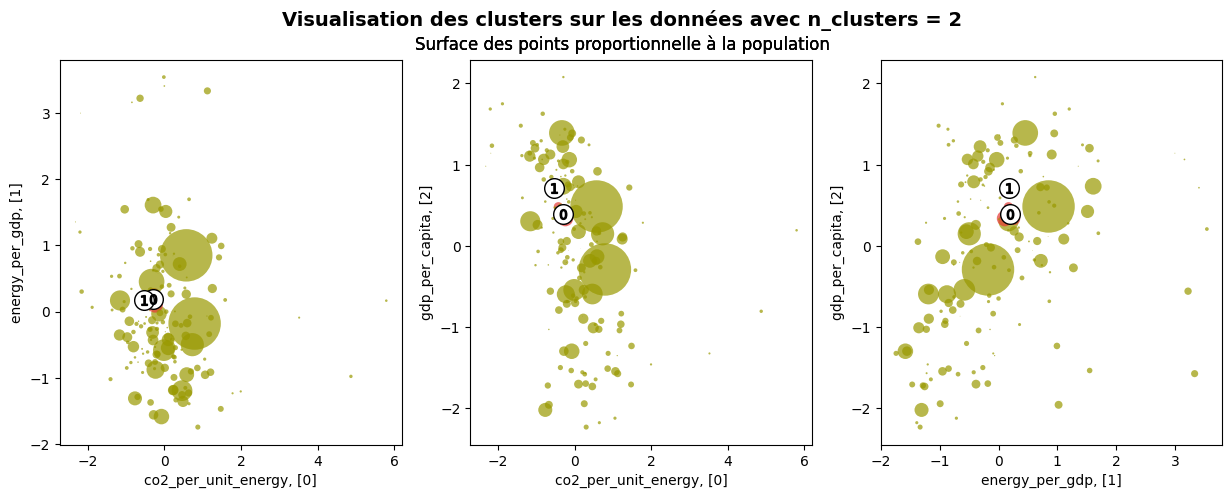

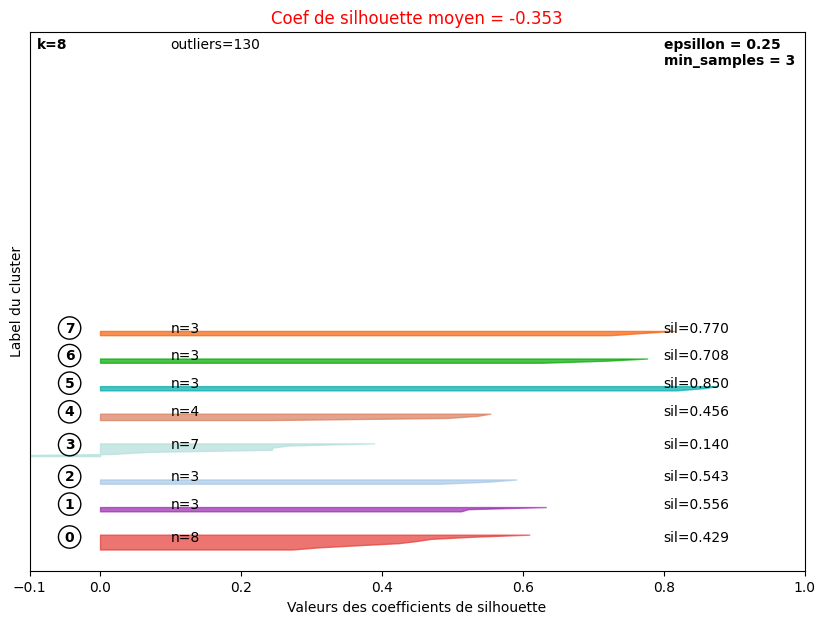

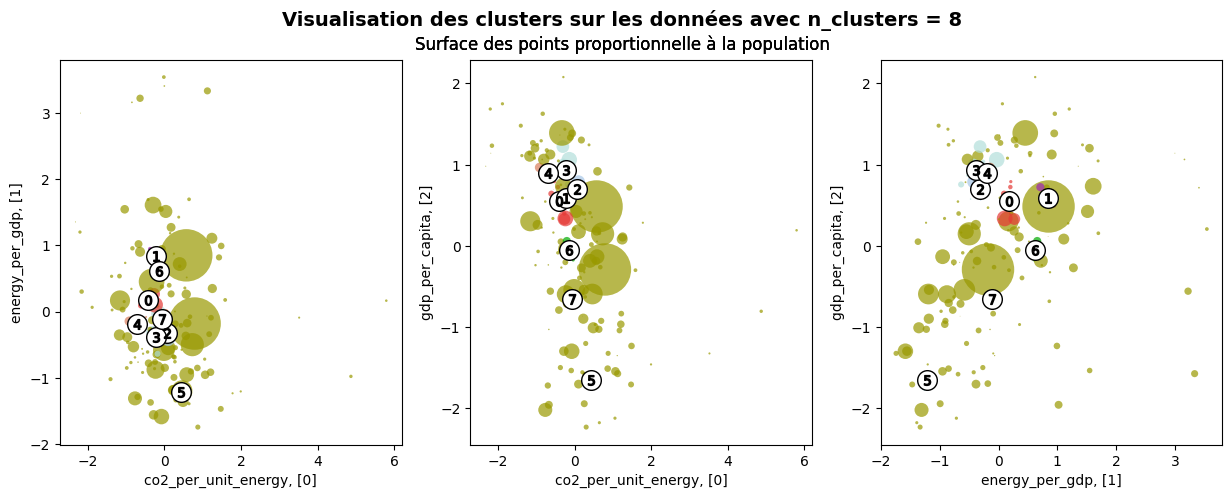

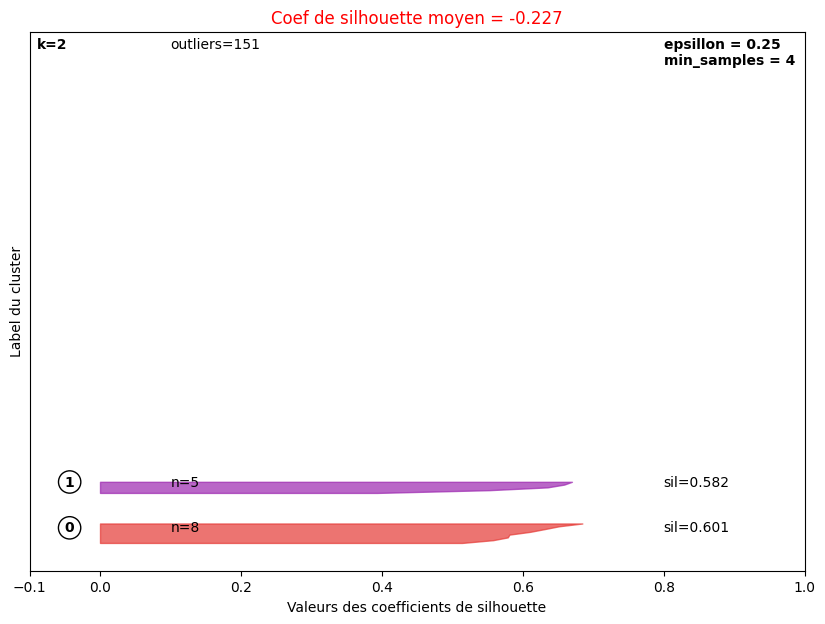

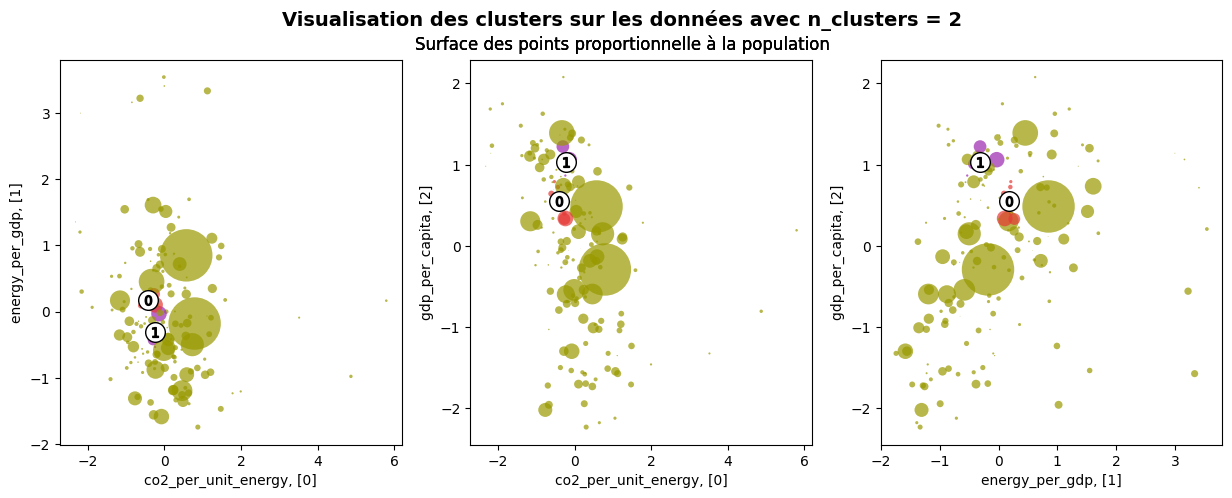

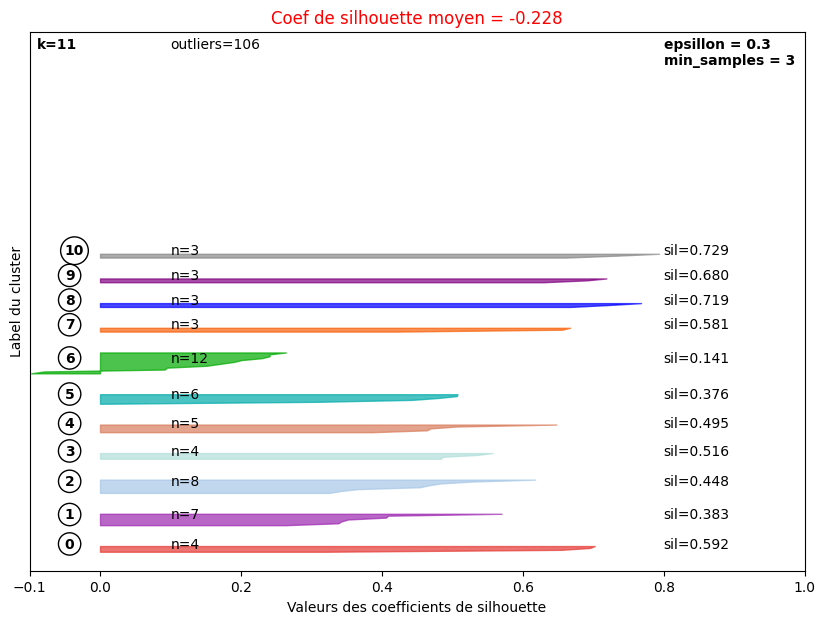

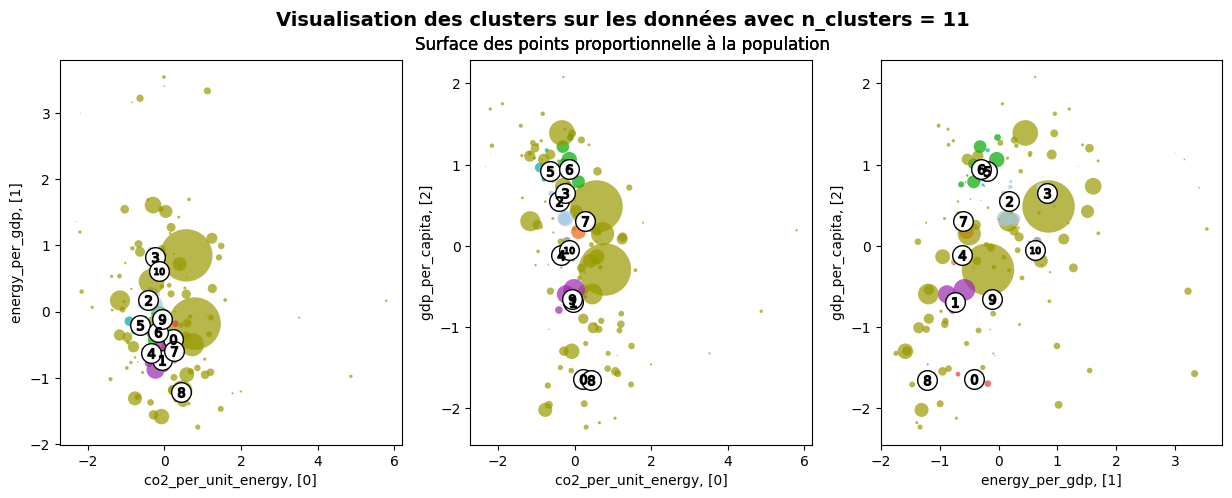

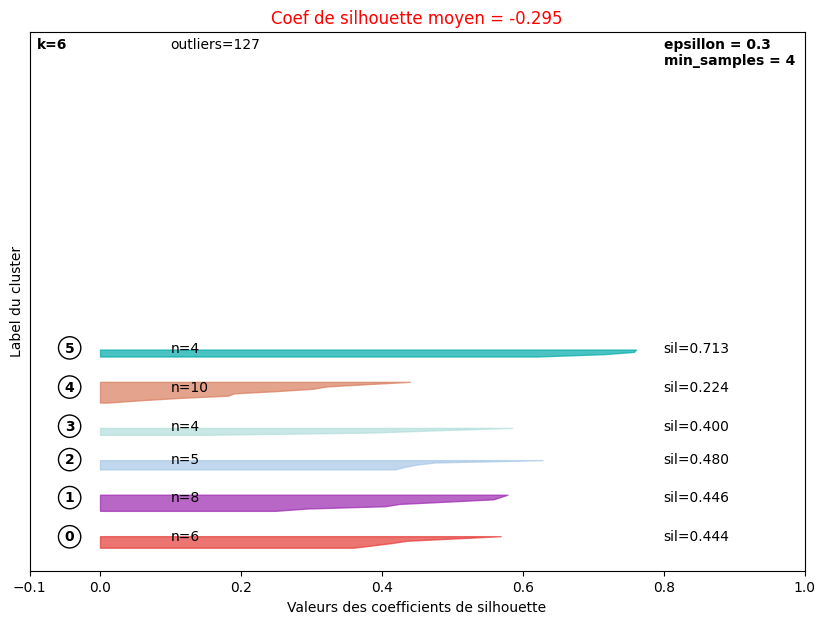

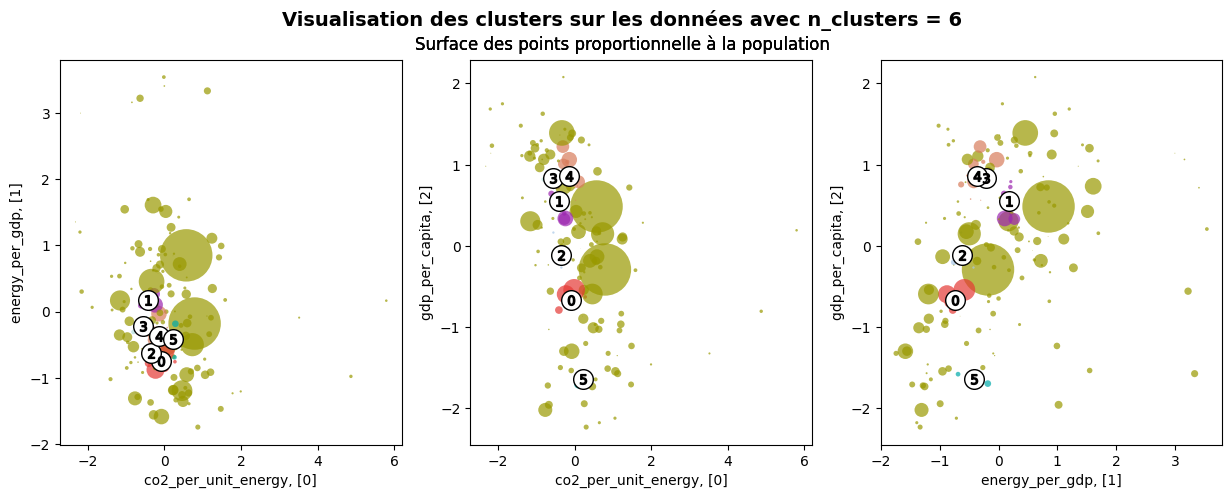

In [8]:
df, X =  preprocessing(df, years, countries, cols, features)
figs = []
silhouette_scores = []
inertia_scores = []


for eps in eps_values:
   for min_samples in min_samples_values:
      
      cluster_labels = dbscan_training(X, eps, min_samples)
      
      n_clusters = len(set(cluster_labels) - {-1})
      if n_clusters > 0:
          silhouette_avg = silhouette_score(X, cluster_labels)
          silhouette_sample_values = silhouette_samples(X, cluster_labels)
      else:
          silhouette_avg = 0
          silhouette_sample_values = np.zeros(cluster_labels.shape)  
      print(">>> ", n_clusters)
      if n_clusters <= 12:
        fig1 = display_silhouettes(X, n_clusters, cluster_labels, eps=eps, min_samples=min_samples, inertia=None)
        # plotting 2D clusters [optional]      
        centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
        fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, df['population'])
      silhouette_scores.append(silhouette_avg)  

# 4/ Analyse - Conclusion :
Le modèle DBSCAN ne semble pas adapté à ces données : beaucoup d'outliers, clusters très petits avec scores de silhouette faible